In [1]:
%load_ext autoreload
%autoreload 2

# hardware
import os
# analysis
import numpy as np
import xarray as xr
import pandas as pd
from scipy.integrate import simps
from scipy.interpolate import RegularGridInterpolator
# vis
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-deep')

# Acoustic tomography package
import atom
# configuration object
from hydra import initialize, compose
from hydra.utils import instantiate
with initialize(version_base=None, config_path="../../conf/"):
    cfg = compose(config_name="configs",)

# Load data

In [46]:
### Array data
atarray = instantiate(cfg.atarray)

### Auxiliary data
auxdata = instantiate(cfg.auxdata)
auxDataPath = "/Users/nhamilt2/Documents/ATom/data/Data_collection_20190815/20190815123732_AcouTomAuxData.txt"
auxdata.loadData(auxDataPath)

### Constants
constants = instantiate(cfg.constants)

### TravelTimeExtractor
ttextractor = atom.signalProc.TravelTimeExtractor.from_netcdf('../extractedTravelTimes_example.nc')

# Linear System object
This object assembles linear system blocks to estimate the bulk flow within the acoustic tomography array. 

It requires:
   - array geometry from the atArray object
   - (filtered) measured travel times from the travelTimeExtractor object

This class is responsible for assembling all the necessary information for the linear system solution as part of the AT process.

$Gf = b$

$G$ is the geometry block (which can also include direct measurements).

$f = [1/c_0, u_0/c_0^2, v0/c_0^2]$ is the vector of unknowns.

$b$ are observed travel times from travelTimeExtractor

The background flow if found through the solution:

$f = (G^{-1} * G)^T (G^{-1} * b)$

- $G = [I, 3] (I==nMics*nSpeakers)$
- $f = [3]$ (see above)
- $b = I$ (travel times for a frame)

In [71]:
ls = atom.backgroundFlow.linearsystem.LinearSystem(
    atarray=atarray.ds,
    measuredTravelTime=ttextractor.ds.filteredMeasuredTravelTimes,
    constants=constants
)

ls.executeProcess()
# update pathID index to match the definition in the atarray object
ls.ds['pathID'] = atarray.ds.pathID
# store linearSystem dataset as netcdf file
ls.to_netcdf('../bulkField_example_data.nc')

The `linearSystem.executeProcess` executes all methods of the LinearSystem in order. This includes building the process block, collecting the observation block, solving the system, and extracting the bulk values.
- `linearSystem.buildProcessBlock()`
- `linearSystem.collectObservationBlock()`
- `linearSystem.solve()`
- `linearSystem.extractBulkValues()`

In [73]:
ls.ds

<xarray.Dataset>
Dimensions:             (frame: 120, pathID: 56, variable: 3, component: 3)
Coordinates:
  * frame               (frame) int64 0 1 2 3 4 5 6 ... 114 115 116 117 118 119
  * pathID              (pathID) object MultiIndex
  * spk                 (pathID) int64 0 0 0 0 0 0 0 1 1 1 ... 6 6 7 7 7 7 7 7 7
  * mic                 (pathID) int64 1 2 3 4 5 6 7 0 2 3 ... 5 7 0 1 2 3 4 5 6
  * variable            (variable) object 'ones' 'ncos' 'nsin'
  * component           (component) int64 0 1 2
Data variables:
    measuredTravelTime  (frame, pathID) float64 0.09498 0.136 ... 0.1961 0.1233
    pathOrientation     (pathID) float64 -0.3769 -0.9134 ... -1.671 -1.935
    pathLength          (pathID) float64 32.52 46.28 76.65 ... 86.81 67.15 41.81
    arrayGeom           (pathID, variable) float64 1.0 -0.9298 ... 0.3562 0.9344
    observationalData   (pathID, frame) float64 0.002921 0.002921 ... 0.002948
    variableBlock       (component, frame) float64 0.002929 ... 9.648e-06
    c                   (frame) float64 341.4 341.2 341.0 ... 342.0 341.8 341.5
    u                   (frame) float64 4.98 4.678 5.111 ... 5.815 5.714 6.154
    v                   (frame) float64 1.815 1.573 1.73 ... 1.151 1.201 1.125
    T                   (frame) float64 290.1 289.7 289.4 ... 291.1 290.6 290.2

In [49]:
ls.ds['time'] = ls.ds['frame']*0.5
ls.ds = ls.ds.swap_dims({'frame':'time'})

In [50]:
auxdata.ds['time'] = auxdata.ds.time.values.astype(float)/10**9

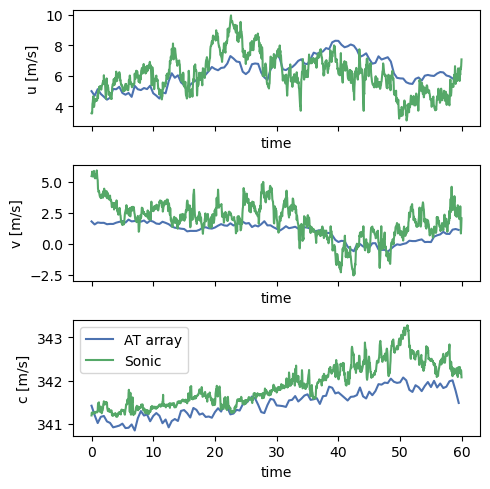

In [57]:
fig, ax = plt.subplots(3,1, figsize=(5,5), sharex=True)

ls.ds.u.plot(ax=ax[0])
auxdata.ds.u.plot(ax=ax[0])

ls.ds.v.plot(ax=ax[1])
auxdata.ds.v.plot(ax=ax[1])

ls.ds.c.plot(ax=ax[2], label='AT array')
auxdata.ds.c.plot(ax=ax[2], label='Sonic')
ax[2].legend()

fig.tight_layout()

In [54]:
ls.ds

<xarray.Dataset>
Dimensions:             (time: 120, pathID: 56, variable: 3, component: 3)
Coordinates:
    frame               (time) int64 0 1 2 3 4 5 6 ... 114 115 116 117 118 119
  * pathID              (pathID) object MultiIndex
    spk                 (pathID) int64 0 0 0 0 0 0 0 1 1 1 ... 6 6 7 7 7 7 7 7 7
    mic                 (pathID) int64 1 2 3 4 5 6 7 0 2 3 ... 5 7 0 1 2 3 4 5 6
  * variable            (variable) object 'ones' 'ncos' 'nsin'
  * component           (component) int64 0 1 2
  * time                (time) float64 0.0 0.5 1.0 1.5 ... 58.0 58.5 59.0 59.5
Data variables:
    measuredTravelTime  (time, pathID) float64 0.09498 0.136 ... 0.1961 0.1233
    pathOrientation     (pathID) float64 -0.3769 -0.9134 ... -1.671 -1.935
    pathLength          (pathID) float64 32.52 46.28 76.65 ... 86.81 67.15 41.81
    arrayGeom           (pathID, variable) float64 1.0 -0.9298 ... 0.3562 0.9344
    observationalData   (pathID, time) float64 0.002921 0.002921 ... 0.002948
    variableBlock       (component, time) float64 0.002929 ... 9.648e-06
    c                   (time) float64 341.4 341.2 341.0 ... 342.0 341.8 341.5
    u                   (time) float64 4.98 4.678 5.111 ... 5.815 5.714 6.154
    v                   (time) float64 1.815 1.573 1.73 ... 1.151 1.201 1.125
    T                   (time) float64 290.1 289.7 289.4 ... 291.1 290.6 290.2